<a href="https://colab.research.google.com/github/kwak9601/Qlearning_OpenAI/blob/main/policy_gradient_new_graphs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import numpy as np
import random
import math
import statistics
import sys
import matplotlib.pyplot as plt
import itertools
from tqdm import tqdm

#The code is to use policy gradient algorithm to optimize multi-objective criteria of WAAM
#the evalulation of policy, though done in real-life, simulate_m() is used to create an 
#approximate value to validate and test the suitability of the code.

# Initial parameter input (pi) = {theta_1, ... , theta_n} where n is number of parameters

# To print without scientific notation
M_w_error_lst =[]
M_h_error_lst = []
count_end = 0
# --- preset values can be altered --- #
sod = 12  # standoff distance [mm]
wfs = 4.4  #  wire feed rate [m/min]
tts = 30  # torch travel speed [cm/min]
volt = 20  #  voltage [V]

#gives width = 9.438 and height = 2.708 mm
init_policy  = [sod, wfs, tts, volt]

epsilon_sod = 0.2# may vary in magnitude for above parameters
epsilon_wfs = 0.2
epsilon_tts = 0.5
epsilon_volt = 0.5

weight_width_error = 0.2
weight_height_error = 0.2
weight_width_deviation = 0.3
weight_height_deviation = 0.3

desired_width = 13 # [mm]
desired_height = 5

step_size = 2

iteration_count = 0
iteration_max = 200

policy_num_of_sets = 6
def main(print_more=False):
  np.set_printoptions(suppress=True)

  # --- preset values can be altered --- #
  sod = 12  # standoff distance [mm]
  wfs = 4.4  #  wire feed rate [m/min]
  tts = 30  # torch travel speed [cm/min]
  volt = 20  #  voltage [V]

  #gives width = 9.438 and height = 2.708 mm
  init_policy  = [sod, wfs, tts, volt]

  epsilon_sod = 0.2# may vary in magnitude for above parameters
  epsilon_wfs = 0.2
  epsilon_tts = 0.5
  epsilon_volt = 0.5

  weight_width_error = 0.2
  weight_height_error = 0.2
  weight_width_deviation = 0.3
  weight_height_deviation = 0.3

  desired_width = 13 # [mm]
  desired_height = 5

  step_size = 2

  iteration_count = 0
  iteration_max = 200

  policy_num_of_sets = 6

  weight_width_error = 0.5 # delete this when the std. dev can be obtained.
  weight_height_error = 0.5
  def eval_obj_func(norm_w_error, norm_h_error):
      
      #TODO:
      #weight_width_deviation * norm_w_deviation_error + 
      #weight_height_deviation + norm_h_deviation_error + will be added as we figure out how to find it
      #in simulate_m() function.
      
      evaluated_f = 1 - (weight_width_error * norm_w_error + 
                        weight_height_error * norm_h_error)
      
      return evaluated_f   

  M_w_error_lst =[]
  M_h_error_lst = []
  count_end = 0
  # this function simulates the evaluation variable, that is normalized:M. 
  def simulate_m(eval_policy): #policy to be evaluated
      global M_w_error_lst
      global M_h_error_lst
      global count_end
      
  #     print(eval_policy)
  #     print(eval_policy[::2]) #shows + - or 0 epsilon
  #     print(eval_policy[1::2]) #shows values corresponding to epsilon
      sod = eval_policy[1::2][0]
      wfs = eval_policy[1::2][1]
      tts = eval_policy[1::2][2]
      volt = eval_policy[1::2][3]
      
      #TODO - think of how std. dev can be represented.... not sure.

      
      dev_width = abs((sod * -1 + wfs* 1 + tts * 1 + volt *1) / 
      (sod + wfs*1 + tts*1 + volt *1))
      
      dev_height = abs((sod *1 + wfs* 1 + tts * -1 + volt * -1) /
                      (sod + wfs* 1 + tts*1 + volt *1))

      #values are found and passed in here.
      # Paper - "Bead geometry prediction for robotic GMAW based rapid maufacturing through a
      #neural network and a second-order regression analysis"

      dev_width = abs( desired_width -  (8.9462 + 1.8088 * wfs - 0.3621 * tts + 0.1739 * volt 
                                        -0.5008 * sod +0.003556 * tts * sod + 0.01667 * volt * sod 
                                        - 0.1169 * wfs * wfs + 0.003137 * tts * tts) )
      dev_height =abs( desired_height - (-0.3514 + 0.4818 * wfs - 0.08477 * tts + 0.4028 * volt
                                        + 0.01431 * sod- 0.006146 * wfs * tts +
                                        0.001168 * tts * tts - 0.012463 * volt * volt) )
      
  #     dev_width = abs ( 8.9462 + 1.8088 * wfs - 0.3621 * tts + 0.1739 * volt  -0.5008 * sod 
  #     +0.003556 * tts * sod + 0.01667 * volt * sod - 0.1169 * wfs * wfs + 0.003137 * tts * tts)
  #     dev_height =abs( -0.3514 + 0.4818 * wfs - 0.08477 * tts + 0.4028 * volt + 0.01431 * sod 
  #     - 0.006146 * wfs * tts +0.001168 * tts * tts - 0.012463 * volt * volt)
      
      
  #     dev_width = abs(0.1* sod + wfs + 0.1* tts - 10* volt)
  #     dev_height = abs(sod + wfs - 10* tts + 0.1*volt)


  #     print('dev width is ' , dev_width)
  #     print('dev height is' , dev_height)
      
  #     print('simulation result, ' , dev_width, 'dev height is ', dev_height)
  #     print(' abs result: ', abs(dev_width) + abs(dev_height))

      #simulation of polices end #normalize
      
      M_w_error_lst.append(dev_width)
      M_h_error_lst.append(dev_height)
      count_end = count_end + 1
      
      if count_end == policy_num_of_sets:
      
          #for graphing purpose
          M_w_error_lst_plot = M_w_error_lst[:]
          M_h_error_lst_plot = M_h_error_lst[:]
  #         print('width error non normalized = ' , M_w_error_lst)
          
          #Normalizing
          M_w_error = M_w_error_lst / np.linalg.norm(M_w_error_lst)
          M_h_error = M_h_error_lst / np.linalg.norm(M_h_error_lst)
          count_end = 0
          M_w_error_lst =[]
          M_h_error_lst = []
          
  #         print('M_w_error is ', (M_w_error))
  #         print('M_h_error is ', (M_h_error))
          
      else:
          M_w_error = None
          M_h_error = None

          M_w_error_lst_plot = None
          M_h_error_lst_plot = None

      return M_w_error, M_h_error, M_w_error_lst_plot, M_h_error_lst_plot

  def avg_criteria_sort(eval_policy, evaluated_f): 
  #     avg_pos =[[] for _ in range(len(eval_policy))]
  #     avg_zero = [[] for _ in range(len(eval_policy))]
  #     avg_neg = [[] for _ in range(len(eval_policy))]
      
      #eval policy is a dict, ie  {0: [1, 20, -1, 15, 0, 33, 1, 3], 1: [0, ...], 2:...}
      avg_pos =[[] for _ in range(int(len(eval_policy[0])/2))]
      avg_zero = [[] for _ in range(int(len(eval_policy[0])/2))]
      avg_neg = [[] for _ in range(int(len(eval_policy[0])/2))]

      #print('eval_policy', eval_policy)
        
      for value in eval_policy: #(0 - policy num of sets)
  #         print('value', value)
          
          every_policy = eval_policy[value] 
          epsilon_value = every_policy[::2] # -1, 0 or 1
          
          for i in range(len(epsilon_value)): #(n = 4 theta parameters)
              if epsilon_value[i] == 1:
                  avg_pos[i].append(evaluated_f[value])
              elif epsilon_value[i] == 0:
                  avg_zero[i].append(evaluated_f[value])
              elif epsilon_value[i] == -1:
                  avg_neg[i].append(evaluated_f[value])
              else:
                  print('ERROR non 1, 0, -1 value as epsilon index')
      
  #     print('avg_zero is ', avg_zero)
  #     print('avg_pos is ', avg_pos)
  #     print('avg_neg is ',avg_neg)

  #     print('pre - avg neg is: ', avg_neg)

      for i in range(int(len(eval_policy[0])/2)):
          avg_pos[i] = statistics.mean(avg_pos[i])
          avg_zero[i] = statistics.mean(avg_zero[i])
          avg_neg[i] = statistics.mean(avg_neg[i])
          
          #----
  #         try:
  #             avg_pos[i] = mean(avg_pos[i]) # avg_xxx is length of n (thetas)
  #         except:
  #             avg_pos[i] = 0  # in case of concidence where no epsilon of 'x 1' was assigned over repeating
  #             #policies per iteration
              
  #         try:
  #             avg_zero[i] = mean(avg_zero[i])
  #         except:
  #             avg_zero[i] = 0
              
  #         try:
  #             avg_neg[i] = mean(avg_neg[i])
  #         except:
  #             avg_neg[i] = 0
              #---
  #     print('post - avg pos is: ', avg_pos)
  #     print('post - avg zer is: ', avg_zero)
  #     print('post - avg neg is: ', avg_neg)
      
      A = []
      for i in range(len(avg_pos)):
          if avg_zero[i] > avg_pos[i] and avg_zero[i] > avg_neg[i]:
              A.append(0)
          else:
              A.append(avg_pos[i] - avg_neg[i])
      
      if all(elements == 0 for elements in A):
          
          #TODO - maybe as A = [ 0000000], pass down A as just is and move on to next iteration w/o exiting.
          
  #         print('Policy does not need change. FInished.')
  #         sys.exit()

          if print_more==True:
              print('Policy does not need change, proceeding with vector A = 0s')
          
          A = [0] * len(init_policy)
          
      else:
          A = A/(np.linalg.norm(A)) * step_size

  #     avg_pos = mean(avg_pos)
  #     avg_zero = mean(avg_zero)
  #     avg_neg = mean(avg_neg)
      
      
      return avg_pos, avg_zero, avg_neg, A



  epsilon_multiplicator = [-1, 0, 1]

  policy = {}

  done = False
  list_for_plot_F = []
  list_for_plot_M1 = []
  list_for_plot_M2 = []
  list_for_plot_dev_w = []
  list_for_plot_dev_h = []
  list_for_policy = []
  while not done:
      epsilon_copy1 = epsilon_multiplicator[:]
      epsilon_copy2 = epsilon_multiplicator[:]
      epsilon_copy3 = epsilon_multiplicator[:]
      epsilon_copy4 = epsilon_multiplicator[:]
      for i in range(policy_num_of_sets):
  #         rand_epsilon1 = random.choice(epsilon_multiplicator)
          rand_epsilon1 = random.choice(epsilon_copy1)
          epsilon_copy1.remove(rand_epsilon1)
          
  #         rand_epsilon2 = random.choice(epsilon_multiplicator)
          rand_epsilon2 = random.choice(epsilon_copy2)
          epsilon_copy2.remove(rand_epsilon2)

  #         rand_epsilon3 = random.choice(epsilon_multiplicator)
          rand_epsilon3 = random.choice(epsilon_copy3)
          epsilon_copy3.remove(rand_epsilon3)

  #         rand_epsilon4 = random.choice(epsilon_multiplicator)
          rand_epsilon4 = random.choice(epsilon_copy4)
          epsilon_copy4.remove(rand_epsilon4)
          
          if (i+1)%3 == 0:
              epsilon_copy1 = epsilon_multiplicator[:]
              epsilon_copy2 = epsilon_multiplicator[:]
              epsilon_copy3 = epsilon_multiplicator[:]
              epsilon_copy4 = epsilon_multiplicator[:]
          
          policy[i] = np.array([rand_epsilon1, sod + epsilon_sod * rand_epsilon1,
                                rand_epsilon2, wfs + epsilon_wfs * rand_epsilon2,
                                rand_epsilon3, tts + epsilon_tts * rand_epsilon3,
                                rand_epsilon4, volt + epsilon_volt * rand_epsilon4])
          a, b, M_w_error_lst_plot, M_h_error_lst_plot = simulate_m(policy[i]) #returns M_1 , M_2 ...
      
      
      evaluated_f = eval_obj_func(a,b)
  #     print('evaluated f is ', mean(evaluated_f))
      list_for_plot_F = list_for_plot_F + [statistics.mean(evaluated_f)]
      list_for_plot_M1 = list_for_plot_M1 + [statistics.mean(a)]
      list_for_plot_M2 = list_for_plot_M2 + [statistics.mean(b)]
      list_for_plot_dev_w = list_for_plot_dev_w + [statistics.mean(M_w_error_lst_plot)]
      list_for_plot_dev_h = list_for_plot_dev_h + [statistics.mean(M_h_error_lst_plot)]
          
      pos, zero, neg, A = avg_criteria_sort(policy, evaluated_f) #evaluated_f= [size of policy num of sets]
      next_policy = [x + y for x, y in zip(A, init_policy)]
      
      sod = next_policy[0]
      wfs = next_policy[1]
      tts = next_policy[2]
      volt = next_policy [3]
      
      iteration_count += 1
      init_policy = next_policy
      
      if iteration_count == 0:  # putting first array in to list for print purpose
          next_policy = [next_policy]
          
      list_for_policy.append(next_policy)
  #     print('next Policy is ', next_policy, 'iteration count: ', iteration_count)

      if iteration_count >= iteration_max:
          if print_more == True:
              print('Last Policy is ', next_policy, 'iteration count: ', iteration_count)
              print('Maximum f obtained: ', max(list_for_plot_F))
              
              #If duplicate of max value found, it lends the first occurence.
              print('Policy that lended maximum f is ', 
                    list_for_policy[list_for_plot_F.index(max(list_for_plot_F))-1],
                  'at iteration #: ', list_for_plot_F.index(max(list_for_plot_F)))

          done = True
  return list_for_plot_F, list_for_plot_M1, list_for_plot_M2, list_for_plot_dev_w, list_for_plot_dev_h

if __name__ == "__main__":
  list_for_plot_F, list_for_plot_M1, list_for_plot_M2, list_for_plot_dev_w, list_for_plot_dev_h = main()

In [4]:
#Run this section only once.

average_over = 50

avg_plot_F = [[] for _ in range(average_over)]
avg_plot_M1 = [[] for _ in range(average_over)]
avg_plot_M2 = [[] for _ in range(average_over)]
avg_plot_dev_w = [[] for _ in range(average_over)]
avg_plot_dev_h = [[] for _ in range(average_over)]

In [5]:


for k in tqdm(range(average_over)):
  list_for_plot_F, list_for_plot_M1, list_for_plot_M2, list_for_plot_dev_w, list_for_plot_dev_h = main()
  avg_plot_F[k] = list_for_plot_F
  avg_plot_M1[k] = list_for_plot_M1
  avg_plot_M2[k] = list_for_plot_M2
  avg_plot_dev_w[k] = list_for_plot_dev_w
  avg_plot_dev_h[k] = list_for_plot_dev_h

N = iteration_max
x = np.arange(N)


100%|██████████| 50/50 [00:14<00:00,  3.34it/s]


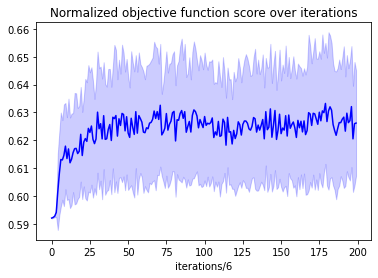

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.


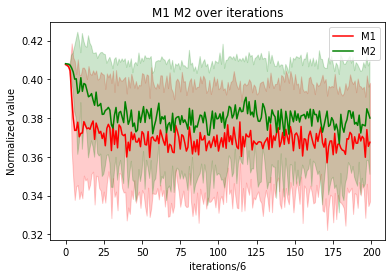

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.


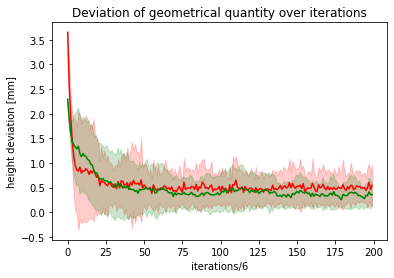

In [6]:
# make in to np array for axis=0 operation - to calc. mean and std dev
avg_plot_F = np.array(avg_plot_F)
avg_plot_M1 = np.array(avg_plot_M1)
avg_plot_M2 = np.array(avg_plot_M2)
avg_plot_dev_w = np.array(avg_plot_dev_w)
avg_plot_dev_h = np.array(avg_plot_dev_h)

avg_plot_F_mean = np.mean(avg_plot_F, axis=0)
avg_plot_F_std = np.std(avg_plot_F, axis=0)
# plt.plot(avg_plot_F_mean)
# plt.title('mean of F')
# plt.show()
avg_plot_M1_mean = np.mean(avg_plot_M1, axis=0)
avg_plot_M1_std = np.std(avg_plot_M1, axis=0)
avg_plot_M2_mean = np.mean(avg_plot_M2, axis=0)
avg_plot_M2_std = np.std(avg_plot_M2, axis=0)

avg_plot_dev_w_mean = np.mean(avg_plot_dev_w, axis=0)
avg_plot_dev_w_std = np.std(avg_plot_dev_w, axis=0)
avg_plot_dev_h_mean = np.mean(avg_plot_dev_h, axis=0)
avg_plot_dev_h_std = np.std(avg_plot_dev_h, axis=0)

# Plotting
plt.plot(x, avg_plot_F_mean, 'b-', label='mean_F')
plt.fill_between(x, avg_plot_F_mean - avg_plot_F_std, avg_plot_F_mean + avg_plot_F_std, color='b', alpha=0.2)
plt.title('Normalized objective function score over iterations')
plt.xlabel('iterations/' + str(policy_num_of_sets))

plt.show()

plt.plot(x, avg_plot_M1_mean, 'r-', label='M1')
plt.fill_between(x, avg_plot_M1_mean - avg_plot_M1_std, avg_plot_M1_mean + avg_plot_M1_std, color='r', alpha=0.2)
plt.xlabel('iterations/' + str(policy_num_of_sets))

plt.plot(x, avg_plot_M2_mean, 'g-', label='M2')
plt.fill_between(x, avg_plot_M2_mean - avg_plot_M2_std, avg_plot_M2_mean + avg_plot_M2_std, color='gb', alpha=0.2)
plt.title('M1 M2 over iterations')
plt.ylabel('Normalized value')

plt.legend()
plt.show()

plt.plot(x, avg_plot_dev_w_mean, 'r-', label='Width deviation')
plt.ylabel('width deviation [mm]')
plt.xlabel('iterations/' + str(policy_num_of_sets))
plt.fill_between(x, avg_plot_dev_w_mean - avg_plot_dev_w_std, avg_plot_dev_w_mean + avg_plot_dev_w_std, color='r', alpha=0.2)

plt.plot(x, avg_plot_dev_h_mean, 'g-', label='Height deviation')
plt.ylabel('height deviation [mm]')
plt.fill_between(x, avg_plot_dev_h_mean - avg_plot_dev_h_std, avg_plot_dev_h_mean + avg_plot_dev_h_std, color='gb', alpha=0.2)
plt.title('Deviation of geometrical quantity over iterations')
plt.show()


#Below outdated


# # avg_plot_F[run] = list_for_plot_F 
# # print(len(avg_plot_F))
# # plt.plot(avg_plot_F[0])
# # plt.show()

# avg_plot_M1[run] = list_for_plot_M1
# avg_plot_M2[run] = list_for_plot_M2

# avg_plot_dev_w[run] = list_for_plot_dev_w
# avg_plot_dev_h[run] = list_for_plot_dev_h
# run += 1
# print("run count: ", run)

# #this averaging only works if data length are equal.
# a = [mean((x for x in xs if x is not None)) for xs in itertools.zip_longest(*avg_plot_F)]
# b = [mean((x for x in xs if x is not None)) for xs in itertools.zip_longest(*avg_plot_M1)]
# c = [mean((x for x in xs if x is not None)) for xs in itertools.zip_longest(*avg_plot_M2)]
# d = [mean((x for x in xs if x is not None)) for xs in itertools.zip_longest(*avg_plot_dev_w)]
# e = [mean((x for x in xs if x is not None)) for xs in itertools.zip_longest(*avg_plot_dev_h)]

In [7]:
print(len(a))
plt.plot(a)
plt.title('Normalized objective function score over iterations')
plt.ylabel('F')
plt.xlabel('iterations/' + str(policy_num_of_sets))

plt.show()

NameError: ignored

In [ ]:
plt.plot(b)

plt.ylabel('M1 - normalized width error')
plt.xlabel('iterations/' + str(policy_num_of_sets))

plt.show()

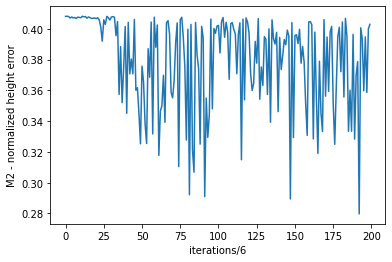

In [ ]:
plt.plot(c)
plt.ylabel('M2 - normalized height error')
plt.xlabel('iterations/' + str(policy_num_of_sets))

plt.show()

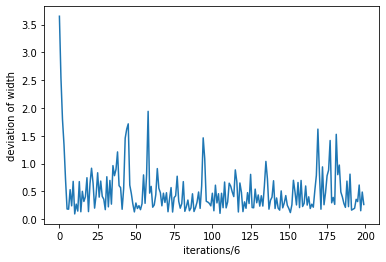

In [ ]:
plt.plot(d)
plt.ylabel('deviation of width')
plt.xlabel('iterations/' + str(policy_num_of_sets))

plt.show()

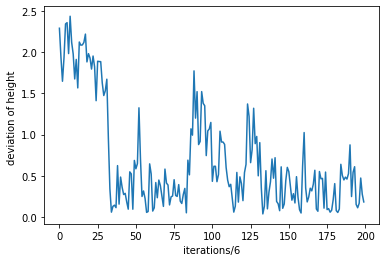

In [ ]:
plt.plot(e)
plt.ylabel('deviation of height ')
plt.xlabel('iterations/' + str(policy_num_of_sets))

plt.show()

[23.57263149 22.20428521 22.26653111 22.25430433 20.89772795 22.52821386
 20.66696162 20.62035406 21.11913146 21.13336006 19.96012369 19.61357813
 20.43527974 20.21335154 18.85465547 17.79367557 17.32821918 18.26603479
 16.71494575 15.77226189 14.49476313 15.42518164 15.03403077 15.82848284
 16.68499305 18.45260362 18.6704768  17.81952284 19.74530106 19.97735675
 20.51948947 20.58777499 20.36214842 21.56969436 21.96403772 21.77800702
 22.42917599 21.98342552 22.66394339 23.66055913 24.69943305 23.84455317
 23.84217584 26.52739932 27.30623794 28.47622721 28.47710052 28.03991151
 26.84241453 27.35398259 27.11403327 26.22286549 25.34043385 27.10603768
 26.57592984 28.89049884 28.912704   28.09501487 27.3194382  26.26097003
 25.31833035 24.3193969  24.48139224 25.19761387 25.87520774 25.61852734
 25.46980834 26.11895257 26.33094848 27.05352844 26.03509434 25.7241938
 26.22978818 26.57783217 28.47152883 28.67403104 27.70231258 27.71302965
 26.66893112 27.1706958  26.61528799 27.17904808 26.

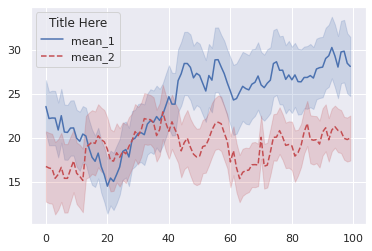

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

sns.set()
N = 100
x = np.arange(N)
mean_1 = 25 + np.random.normal(0.1, 1, N).cumsum()
print(mean_1)
std_1 = 3 + np.random.normal(0, .08, N).cumsum()
print(std_1)
mean_2 = 15 + np.random.normal(0.2, 1, N).cumsum()

std_2 = 4 + np.random.normal(0, .1, N).cumsum()

plt.plot(x, mean_1, 'b-', label='mean_1')
plt.fill_between(x, mean_1 - std_1, mean_1 + std_1, color='b', alpha=0.2)
plt.plot(x, mean_2, 'r--', label='mean_2')
plt.fill_between(x, mean_2 - std_2, mean_2 + std_2, color='r', alpha=0.2)

plt.legend(title='Title Here')
plt.show()

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95
 96 97 98 99]


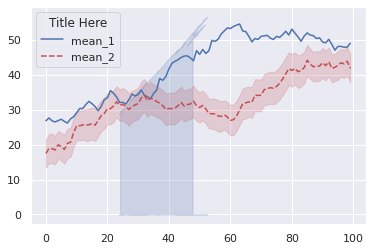

In [14]:
std_dev_testinglist = np.array([[1,2], [1,5], [1,5], [1,5], [1,5], [1,5], [1,5], [1,5], [1,5], [1,5], [1,5], [1,5], [1,5], [1,5], [1,5]])
std_dev_test = np.std(std_dev_testinglist, axis=0)
print(std_dev_test)


[0.         0.74833148]
